In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
from PIL import Image
import re
import glob
import os
import cv2
import copy
import json
import pdb

import chainer
from chainer import functions as F
from chainer import links as L
from chainer import cuda
from chainer import training
from chainer import iterators
from chainer.training import extensions

# train YOLOv2 on MSCOCO Detection

## 概要
- 基本的にはFaster R-CNNのRPNの精度を高めたもの
- 入力を(224, 224)の画像とすると、出力されるfeatureは(7, 7)
- featureの１マスが入力画像の(32, 32)の領域に対応しているとみなす
- featureの各マスについて、
  - そこに物体がある確率(confidence)
  - 物体があるとすればcategoryは何か
  - そこに物体がある場合の矩形の中心(x, y), 大きさ(w, h)
    - (x, y)はマスの中心を(0.5, 0.5)として[0, 1]の値
    - (w, h)はanchor box(後述)の何倍であるか
- anchor boxは基準となる矩形であり、これとground truthのIoUが高いときそこには物体がある(confidence=1)と考える
- 詳しいことは[この辺り](https://github.com/leetenki/YOLOv2/blob/master/YOLOv2.md)を読んで下さい。

## prepare YOLOv2
- YOLOv2と学習に必要な関数の用意

In [2]:
# calc Intersection over Union of two bounding boxes.
def calc_iou(box0, box1, xp):
    # box: (x, y, w, h)
    x0 = xp.maximum(
        (box0[0] - box0[2] / 2), (box1[0] - box1[2] / 2))
    y0 = xp.maximum(
        (box0[1] - box0[3] / 2), (box1[1] - box1[3] / 2))
    x1 = xp.minimum(
        (box0[0] + box0[2] / 2), (box1[0] + box1[2] / 2))
    y1 = xp.minimum(
        (box0[1] + box0[3] / 2), (box1[1] + box1[3] / 2))
    mask = (x1 > x0) * (y1 > y0)
    intersection = (x1 - x0) * (y1 - y0) * mask
    sum_box = box0[2] * box0[3] + box1[2] * box1[3] - intersection
    return xp.array(intersection / sum_box)

# make high resolution feature.
def reorg(x, stride=2):
    b, ch, h, w = x.shape
    out_h, out_w, out_ch = h // stride, w // stride, ch * (stride**2)
    out = F.reshape(x, (b, ch, out_h, stride, out_w, stride))
    out = F.transpose(out, (0, 1, 3, 5, 2, 4))
    out = F.reshape(out, (b, out_ch, out_h, out_w))
    return out

In [3]:
class ConvBlock(chainer.Chain):
    def __init__(self, in_ch, out_ch, ksize, use_bn=True, activation=True):
        self.use_bn = use_bn
        self.activation = activation
        pad = (ksize - 1) // 2
        layers = {}
        layers['conv'] = L.Convolution2D(in_ch, out_ch, ksize=ksize,
                                         stride=1, pad=pad)
        if use_bn:
            layers['bn'] = L.BatchNormalization(out_ch)
        super(ConvBlock, self).__init__(**layers)

    def __call__(self, x):
        h = self.conv(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation:
            h = F.leaky_relu(h, slope=0.1)
        return h

In [4]:
class YOLOv2(chainer.Chain):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.thresh = 0.6
        self.anchors = [[0.57273, 0.677385],
                        [1.87446, 2.06253 ],
                        [3.33843, 5.47434 ],
                        [7.88282, 3.52778 ],
                        [9.77052, 9.16828 ]]
        self.n_anchors = len(self.anchors)
        # learning scale
        self.lambda_box_ls_obj    = 1.0
        self.lambda_box_ls_noobj  = 0.01
        self.lambda_conf_ls_obj   = 5.0
        self.lambda_conf_ls_noobj = 0.5

        super(YOLOv2, self).__init__(
            cb1  = ConvBlock(   3,   32, 3),
            cb2  = ConvBlock(  32,   64, 3),
            cb3  = ConvBlock(  64,  128, 3),
            cb4  = ConvBlock( 128,   64, 1),
            cb5  = ConvBlock(  64,  128, 3),
            cb6  = ConvBlock( 128,  256, 3),
            cb7  = ConvBlock( 256,  128, 1),
            cb8  = ConvBlock( 128,  256, 3),
            cb9  = ConvBlock( 256,  512, 3),
            cb10 = ConvBlock( 512,  256, 1),
            cb11 = ConvBlock( 256,  512, 3),
            cb12 = ConvBlock( 512,  256, 1),
            cb13 = ConvBlock( 256,  512, 3),
            cb14 = ConvBlock( 512, 1024, 3),
            cb15 = ConvBlock(1024,  512, 1),
            cb16 = ConvBlock( 512, 1024, 3),
            cb17 = ConvBlock(1024,  512, 1),
            cb18 = ConvBlock( 512, 1024, 3),
            cb19 = ConvBlock(1024, 1024, 3),
            cb20 = ConvBlock(1024, 1024, 3),
            cb21 = ConvBlock(3072, 1024, 3),
            cb22 = ConvBlock(1024, self.n_anchors * (5 + n_classes),
                           1, use_bn=False, activation=False),
        )

    def calc_feat(self, x):
        h = x
        for i in range(1, 23):
            h = self['cb{}'.format(i)](h)
            if i == 13:
                hires_feat = reorg(h)
            if i in [1, 2, 5, 8, 13]:
                h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0)
            if i == 20:
                h = F.concat((hires_feat, h), axis=1)
        return h

    def forward(self, x):
        feat = self.calc_feat(x)
        b, ch, grid_h, grid_w = feat.shape
        feat = F.reshape(
            feat, (b, self.n_anchors, self.n_classes + 5, grid_h, grid_w))
        x, y, w, h, conf, cls = F.split_axis(feat, (1, 2, 3, 4, 5), axis=2)
        x = F.sigmoid(x)
        y = F.sigmoid(y)
        conf = F.sigmoid(conf)
        cls = F.transpose(cls, (0, 2, 1, 3, 4))
        cls = F.softmax(cls)
        return x, y, w, h, conf, cls, (b, ch, grid_h, grid_w)

    def __call__(self, x, t):
        chainer.config.train = True
        # forward
        x, y, w, h, conf, cls, (batch, ch, grid_h, grid_w) = self.forward(x)

        # make target
        # TODO: めちゃ遅いのでなんとかする
        anchors = self.xp.array(self.anchors, dtype=np.float32)

        # prepare target array
        t_w = self.xp.zeros_like(w)
        t_h = self.xp.zeros_like(h)
        t_x = self.xp.zeros_like(x) + 0.5
        t_y = self.xp.zeros_like(y) + 0.5
        t_conf = self.xp.zeros_like(conf)
        t_cls = cls.data.copy()

        # learning scales
        box_ls = self.xp.zeros_like(x) + self.lambda_box_ls_noobj # 0.1
        conf_ls = self.xp.zeros_like(conf) + self.lambda_conf_ls_noobj

        # to absolute coordinates
        w_anchors_abs = anchors[:, 1] / grid_w
        h_anchors_abs = anchors[:, 0] / grid_h
        x_shift, y_shift = self.xp.meshgrid(
            self.xp.linspace(0, grid_w - 1, grid_w, dtype=np.float32),
            self.xp.linspace(0, grid_h - 1, grid_h, dtype=np.float32))
        x_abs = (x + x_shift) / grid_w
        y_abs = (y + y_shift) / grid_h
        w_abs = F.exp(w) * w_anchors_abs[..., None, None, None]
        h_abs = F.exp(h) * h_anchors_abs[..., None, None, None]

        for b in range(batch):
            for t_box in t[b]:
                # prepare t_pos and t_cls
                ind_w = int(t_box['x'] * grid_w)
                ind_h = int(t_box['y'] * grid_h)
                ious = calc_iou((0, 0, t_box['w'], t_box['h']),
                                (0, 0, w_anchors_abs, h_anchors_abs), self.xp)
                ind_anchor = self.xp.argmax(ious)
                box_ls[b, ind_anchor, :, ind_h, ind_w] = self.lambda_box_ls_obj
                t_x[b, ind_anchor, :, ind_h, ind_w] = t_box['x'] * grid_w - ind_w
                t_y[b, ind_anchor, :, ind_h, ind_w] = t_box['y'] * grid_h - ind_h
                t_w[b, ind_anchor, :, ind_h, ind_w] = self.xp.log(
                    t_box['w'] / w_anchors_abs[ind_anchor])
                t_h[b, ind_anchor, :, ind_h, ind_w] = self.xp.log(
                    t_box['h'] / h_anchors_abs[ind_anchor])
                t_cls[b, :, ind_anchor, ind_h, ind_w] = 0.
                t_cls[b, int(t_box['label']), ind_anchor, ind_h, ind_w] = 1.

                # prepare t_conf
                iou_pred = calc_iou((t_box['x'], t_box['y'], t_box['w'], t_box['h']),
                                    (x_abs[b].data,
                                     y_abs[b].data,
                                     w_abs[b].data,
                                     h_abs[b].data),
                                    self.xp)
                t_conf[b, ind_anchor, :, ind_h, ind_w] = iou_pred[ind_anchor, :, ind_h, ind_w]
                conf_ls[b][(iou_pred > self.thresh) * 
                           (conf_ls[b] != self.lambda_conf_ls_obj)] = 0.
                conf_ls[b, ind_anchor, :, ind_h, ind_w] = self.lambda_conf_ls_obj
                #pdb.set_trace()

            # calc Loss
            loss_x = F.sum((t_x - x) ** 2 * box_ls) / 2
            loss_y = F.sum((t_y - y) ** 2 * box_ls) / 2
            loss_w = F.sum((t_w - w) ** 2 * box_ls) / 2
            loss_h = F.sum((t_h - h) ** 2 * box_ls) / 2
            loss_conf = F.sum((t_conf - conf) ** 2 * conf_ls) / 2
            loss_cls = F.sum((t_cls - cls) ** 2) / 2
            self.loss = (loss_x + loss_y + loss_w + loss_h + 
                         loss_conf + loss_cls) / batch
            chainer.report({'loss': self.loss}, self)
        return self.loss

    def predict(self, x):
        chainer.config.train = False
        # forward
        x, y, w, h, conf, cls, (batch, ch, grid_h, grid_w) = self.forward(x)
        # to absolute coordinates
        anchors = self.xp.array(self.anchors, dtype=np.float32)
        w_anchors_abs = anchors[:, 1, None, None, None] / grid_w
        h_anchors_abs = anchors[:, 0, None, None, None] / grid_h
        x_shift, y_shift = self.xp.meshgrid(
            self.xp.linspace(0, grid_w - 1, grid_w, dtype=np.float32),
            self.xp.linspace(0, grid_h - 1, grid_h, dtype=np.float32))
        x_abs = (x + x_shift) / grid_w
        y_abs = (y + y_shift) / grid_h
        w_abs = F.exp(w) * w_anchors_abs
        h_abs = F.exp(h) * h_anchors_abs
        return x_abs, y_abs, w_abs, h_abs, conf, cls

## prepare MSCOCO Dataset
### download dataset
- 上から実行していくとMSCOCOデータセットがダウンロードされ使えるようになります(たぶん)
- それなりの空き容量が必要です

In [ ]:
# Download MSCOCO dataset
!wget http://msvocds.blob.core.windows.net/coco2014/train2014.zip
!wget http://msvocds.blob.core.windows.net/coco2014/val2014.zip
!wget http://msvocds.blob.core.windows.net/annotations-1-0-3/instances_train-val2014.zip

# unzip dataset
!unzip ./train2014.zip
!unzip ./val2014.zip
!unzip ./instances_train-val2014.zip

In [ ]:
with open('./annotations/instances_train2014.json') as f:
    annotations = json.load(f)

In [ ]:
annotations['categories']

In [ ]:
# ひとまず画像を見てみる

ind = 1000
image_id = annotations['annotations'][ind]['image_id']
bbox = annotations['annotations'][ind]['bbox']
annotations['annotations'][ind]['category_id']

img = Image.open(glob.glob('./train2014/*' + str(image_id) + '*.jpg')[0])
img = np.array(img, dtype=np.float32)
bbox = list(map(int, bbox))
img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3]), (120, 0, 0), 3)
plt.imshow(img)

### Prepare Iterator

In [5]:
# image pathとannotationを対応付ける
def load_data(annotation_file):
    with open(annotation_file) as f:
        annotations = json.load(f)
    data = {}
    for img in annotations['images']:
        data[img['id']] = {'file_name':img['file_name'], 'annos':[]}
    for anno in annotations['annotations']:
        if anno['iscrowd'] == 1:
            continue
        img_id = anno['image_id']
        cat_id = anno['category_id']
        bbox   = np.array(anno['bbox'], dtype=np.float32) #lefttop_x, y, w, h
        data[img_id]['annos'] += [(bbox, cat_id)]
    data = list(data.values())
    return data

In [6]:
# 画像読み込み
def _read_img_as_array(img_path, annotation, size=(224, 224), augmentation=True):
    img = Image.open(img_path)
    w_img, h_img = img.size
    annos = copy.deepcopy(annotation)
    aug_flag = augmentation and np.random.random() > 0.5
    # set resize parameters
    if aug_flag:
        if h_img > w_img:
            w_resize = np.random.randint(size[0], size[0] * 1.2)
            h_resize = np.random.normal(h_img * (w_resize / w_img), w_resize * 0.1)
            h_resize = int(np.max([h_resize, size[1]]))
        else:
            h_resize = np.random.randint(size[1], size[1] * 1.2)
            w_resize = np.random.normal(w_img * (h_resize / h_img), h_resize * 0.1)
            w_resize = int(np.max([w_resize, size[0] + 1]))
    else:
        if h_img > w_img:
            w_resize = size[0]
            h_resize = int(np.ceil(h_img * w_resize / w_img))
        else:
            h_resize = size[1]
            w_resize = int(np.ceil(w_img * h_resize / h_img))
    for anno in annos:
        box, cls = anno
        box[[0, 2]] *= w_resize / w_img
        box[[1, 3]] *= h_resize / h_img
    img = np.array(img.resize((w_resize, h_resize)), dtype=np.float32)

    # crop
    offset_x = np.random.randint(0, w_resize - size[0] + 1)
    offset_y = np.random.randint(0, h_resize - size[1] + 1)
    img = img[offset_y:offset_y + size[1], offset_x:offset_x + size[0]]
    img /= 255.
    
    if aug_flag:
        # randomly shift gamma
        random_gamma = np.random.uniform(0.8, 1.2)
        img = img ** random_gamma
        # randomly shift brightness
        random_brightness = np.random.uniform(0.5, 2.0)
        img = img * random_brightness
        # randomly shift color
        random_colors = np.random.uniform(0.8, 1.2, 3)
        img *= random_colors
        # saturate
        img = np.clip(img,  0., 1.)
    
    t = []
    for anno in annos:
        box, cls = anno
        x_tl = max(0, box[0] - offset_x)
        y_tl = max(0, box[1] - offset_y)
        x_br = min(x_tl + box[2], size[0])
        y_br = min(y_tl + box[3], size[1])
        x = ((x_tl + x_br) / 2) / size[0]
        y = ((y_tl + y_br) / 2) / size[1]
        w = (x_br - x_tl) / size[0]
        h = (y_br - y_tl) / size[0]
        if w > 0 and h > 0:
            t.append({'x': x, 'y': y, 'w': w, 'h': h, 'label': int(cls)})
    return img, t

In [7]:
# TODO: img_sizeをランダムに変更できるようにする
class Dataset(chainer.dataset.dataset_mixin.DatasetMixin):
    def __init__(self, annotations, root='./', img_size=(224, 224),
                 augmentation=True):
        self.data = load_data(annotations)
        self._root = root
        self.augmentation = augmentation
        self.img_size = img_size

    def __len__(self):
        return len(self.data)

    def get_example(self, i):
        annos = self.data[i]['annos']
        file_name = self.data[i]['file_name']
        file_path = os.path.join(self._root, file_name)
        try:
            x, t = _read_img_as_array(file_path, annos, size=self.img_size,
                                      augmentation=self.augmentation)
            x = x.transpose(2, 0, 1)
        except:
            x = np.zeros((3, self.img_size[1], self.img_size[0]), dtype=np.float32)
            t = []
            print('load error.', file_name)
        return x, t

## Train

In [8]:
# gradientにnoiseを加える。
# 学習が安定する、気がする（AdamでもMomentum SGD程度の精度が出るようになるような（要検証））。
def noise_proportional_to_gradient(xp, g, hook):
    shape = g.shape
    dtype = g.dtype
    std = g.std()
    return xp.random.normal(0, std * hook.gamma, shape).astype(dtype)


class GradientNoise(object):
    name = 'GradientNoise'
    call_for_each_param = True

    def __init__(self, gamma=0.01, noise_func=noise_proportional_to_gradient):
        self.gamma = gamma
        self.noise_func = noise_func

    def __call__(self, rule, param):
        g = param.grad
        xp = cuda.get_array_module(g)
        with cuda.get_device_from_array(g) as dev:
            noise = self.noise_func(xp, g, self)
            if int(dev) == -1:
                g += noise
            else:
                kernel = cuda.elementwise(
                    'T noise', 'T g', 'g += noise', 'gradient_noise')
                kernel(noise, g)

In [9]:
# batchのoriginalのままだと失敗するので書き換える
import numpy
import six

from chainer import cuda


def to_device(device, x):
    if device is None:
        return x
    elif device < 0:
        return cuda.to_cpu(x)
    else:
        return cuda.to_gpu(x, device)


def concat_examples(batch, device=None):
    if len(batch) == 0:
        raise ValueError('batch is empty')
    result = []
    result.append(to_device(device, _concat_arrays(
        [example[0] for example in batch])))
    result.append([example[1] for example in batch])
    return tuple(result)


def _concat_arrays(arrays):
    if not isinstance(arrays[0], numpy.ndarray) and not isinstance(arrays[0], cuda.ndarray):
        arrays = numpy.asarray(arrays)
    xp = cuda.get_array_module(arrays[0])
    with cuda.get_device_from_array(arrays[0]):
        return xp.concatenate([array[None] for array in arrays])

In [10]:
model = YOLOv2(91)
optimizer = chainer.optimizers.Adam(1e-4)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(1e-5))
optimizer.add_hook(GradientNoise(0.01))

In [11]:
# 設定
epoch = 50
out_dir = './result/'
batchsize = 4

snapshot_interval = (5000, 'iteration')
report_interval = (10, 'iteration')

In [12]:
dataset = Dataset('../../detection/annotations/instances_train2014.json',
                  root='../../detection/train2014/', augmentation=True, img_size=(448, 448))
#train_iter = iterators.SerialIterator(dataset, batchsize, repeat=True, shuffle=True)
train_iter = iterators.MultiprocessIterator(dataset, batchsize, repeat=True, shuffle=True, n_processes=2)
updater = training.StandardUpdater(train_iter, optimizer, device=0, converter=concat_examples)

In [13]:
trainer = training.Trainer(updater, (epoch, 'epoch'), out=out_dir)

trainer.extend(extensions.dump_graph('main/loss'))
trainer.extend(extensions.snapshot(), trigger=snapshot_interval)
trainer.extend(extensions.snapshot_object(
    model, 'model_iter_{.updater.iteration}'), trigger=snapshot_interval)
trainer.extend(extensions.LogReport(trigger=report_interval))
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'main/loss']),
               trigger=report_interval)

In [ ]:
# load snapshot
chainer.serializers.load_npz('./result/snapshot_iter_10000', trainer)

In [ ]:
trainer.run()

epoch       iteration   main/loss 
0           10          84.6059     
0           20          51.4162     
0           30          35.138      
0           40          27.6304     
0           50          18.0684     
0           60          16.3589     
0           70          15.4885     
0           80          14.5192     
0           90          11.8672     
0           100         13.7134     
0           110         11.3512     
0           120         12.6823     
0           130         13.0583     
0           140         12.3139     
0           150         12.5057     
0           160         13.1252     
0           170         9.26283     
0           180         9.3905      
0           190         7.73859     
0           200         12.6654     
0           210         9.66299     
0           220         9.00578     
0           230         11.3694     
0           240         15.0425     
0           250         10.8173     
0           260         11.8953     
0  

0           8180        8.34353     
0           8190        8.44217     
0           8200        6.76644     
0           8210        6.0202      
0           8220        12.0755     
0           8230        9.16879     
0           8240        8.12089     
0           8250        9.36106     
0           8260        8.25181     
0           8270        8.01765     
0           8280        9.01614     
0           8290        7.8593      
0           8300        6.59779     
0           8310        8.30588     
0           8320        8.07845     
0           8330        7.01028     
0           8340        7.76412     
0           8350        7.40242     
0           8360        9.42498     
0           8370        11.8447     
0           8380        9.29903     
0           8390        6.2829      
0           8400        8.50099     
0           8410        7.11881     
0           8420        9.78547     
0           8430        11.0625     
0           8440        7.65299     
0

0           10220       7.62332     
0           10230       6.6739      
0           10240       7.60748     
0           10250       9.03698     
0           10260       7.10541     
0           10270       7.44428     
0           10280       8.47503     
0           10290       7.56638     
0           10300       8.22833     
0           10310       8.49461     
0           10320       9.92778     
0           10330       9.68398     
0           10340       7.44194     
0           10350       5.89714     
0           10360       7.82651     
0           10370       5.86523     
0           10380       8.44583     
0           10390       7.6872      
0           10400       7.57529     
0           10410       6.24247     
0           10420       7.66667     
0           10430       6.39328     
0           10440       5.8794      
0           10450       7.9217      
0           10460       7.52052     
0           10470       8.67063     
0           10480       7.79768     
0

0           12150       8.65892     
load error. COCO_train2014_000000211867.jpg
0           12160       6.9346      
0           12170       8.00448     
0           12180       7.12289     
0           12190       10.2059     
0           12200       6.96002     
0           12210       9.55011     
0           12220       9.68437     
0           12230       6.48459     
load error. COCO_train2014_000000204792.jpg
0           12240       9.48087     
0           12250       6.19885     
load error. COCO_train2014_000000005294.jpg
0           12260       6.55962     
0           12270       6.43262     
0           12280       8.16537     
0           12290       5.91294     
0           12300       7.23242     
0           12310       7.88201     
0           12320       8.28892     
0           12330       6.31323     
0           12340       5.58343     
0           12350       8.67534     
0           12360       8.31745     
load error. COCO_train2014_000000217341.jpg
load error

0           13970       6.43809     
0           13980       8.04843     
0           13990       6.42255     
0           14000       6.51533     
0           14010       6.81652     
0           14020       7.2852      
0           14030       5.77049     
0           14040       6.69785     
0           14050       8.49673     
0           14060       8.44275     
0           14070       7.23371     
0           14080       7.86779     
0           14090       5.66256     
0           14100       8.41567     
0           14110       7.57565     
load error. COCO_train2014_000000520479.jpg
0           14120       6.41108     
0           14130       9.35072     
0           14140       7.80294     
0           14150       8.12551     
load error. COCO_train2014_000000008794.jpg
0           14160       8.33734     
0           14170       8.08585     
0           14180       7.6833      
0           14190       6.88216     
0           14200       6.75642     
0           14210       

## Test

In [18]:
test_dataset = Dataset('../../detection/annotations/instances_val2014.json',
                        root='../../detection/val2014/', augmentation=False, img_size=(448, 448))
test_iter = iterators.SerialIterator(test_dataset, 1, repeat=True, shuffle=True)

Exception ignored in: <bound method ZipFile.__del__ of <zipfile.ZipFile file=<_io.BufferedWriter name='/home/ubuntu/data/da-deeplearning-lab/detection/result/tmpsnapshot_iter_500009s8s20v'> mode='w'>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/zipfile.py", line 1650, in __del__
    self.close()
  File "/usr/lib/python3.6/zipfile.py", line 1659, in close
    raise ValueError("Can't close the ZIP file while there is "
ValueError: Can't close the ZIP file while there is an open writing handle on it. Close the writing handle before closing the zip.


In [55]:
def show_rectangls(img, recs):
    _img = img.copy()
    for r in recs:
        x0 = max(0, int((r['x'] - r['w'] / 2) * img.shape[1]))
        x1 = min(int((r['x'] + r['w'] / 2) * img.shape[1]), img.shape[1])
        y0 = max(0, int((r['y'] - r['h'] / 2) * img.shape[0]))
        y1 = min(int((r['y'] + r['h'] / 2) * img.shape[0]), img.shape[0])
        _img = cv2.rectangle(_img, (x0, y0), (x1, y1), (120, 0, 0), 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(_img)


def get_rectangles(x_abs, y_abs, w_abs, h_abs, conf, cls):
    rectangls = []
    batch, anchor, _, H, W = x_abs.shape
    for b in range(batch):
        recs_batch = []
        ind = conf[b] > 0.05
        xs = x_abs[b, ind]
        ys = y_abs[b, ind]
        ws = w_abs[b, ind]
        hs = h_abs[b, ind]
        confs = conf[b, ind]
        clses = cls[b][:, ind[:,0]].argmax(axis=0)
        for i in range(len(xs)):
            recs_batch.append(
                {'x': xs[i], 'y': ys[i], 'w': ws[i], 'h': hs[i],
                 'label': int(clses[i]), 'conf':confs[i]})
        rectangls += [recs_batch]
    return rectangls


def nms(recs, iou_thresh=0.5):
    nms_output = []
    n_recs = len(recs)
    rejects = []
    for i in range(n_recs):
        xi = recs[i]['x']
        yi = recs[i]['y']
        wi = recs[i]['w']
        hi = recs[i]['h']
        ci = recs[i]['conf']
        for j in range(i+1, n_recs):
            if j in rejects:
                continue
            xj = recs[j]['x']
            yj = recs[j]['y']
            wj = recs[j]['w']
            hj = recs[j]['h']
            cj = recs[j]['conf']
            if calc_iou((xi, yi, wi, hi), (xj, yj, wj, hj), np) > iou_thresh:
                if ci > cj:
                    rejects.append(j)
                else:
                    rejects.append(i)
        if i not in rejects:
            nms_output.append(recs[i])
    return nms_output


def demo(img):
    if len(img.shape) == 3:
        img = img[None, ...]
    if img.shape[3] == 3:
        img = img.transpose(0, 3, 1, 2)
    if model.xp == np:
        img = cuda.to_cpu(img)
    else:
        img = cuda.to_gpu(img)
    outputs = [cuda.to_cpu(o.data) for o in model.predict(img)]
    recs = get_rectangles(*outputs)[0]
    recs = nms(recs)
    show_rectangls(cuda.to_cpu(img)[0].transpose(1, 2, 0), recs)

In [57]:
batch = test_iter.__next__()
img = batch[0][0][None,...]
t   = batch[0][1]

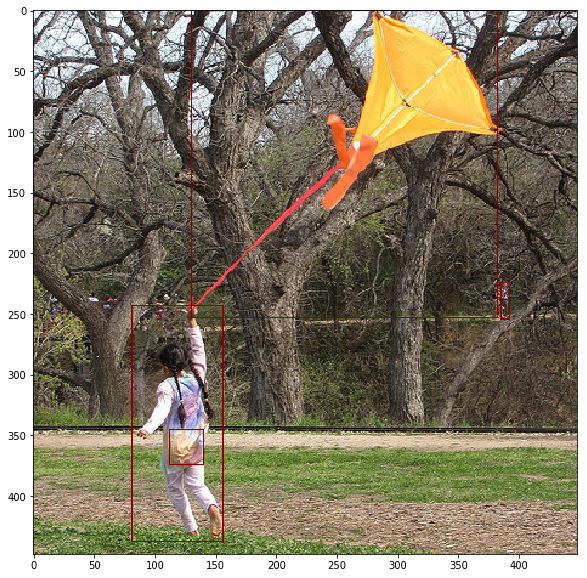

In [58]:
#grand truth
show_rectangls(img[0].transpose(1,2,0), t)

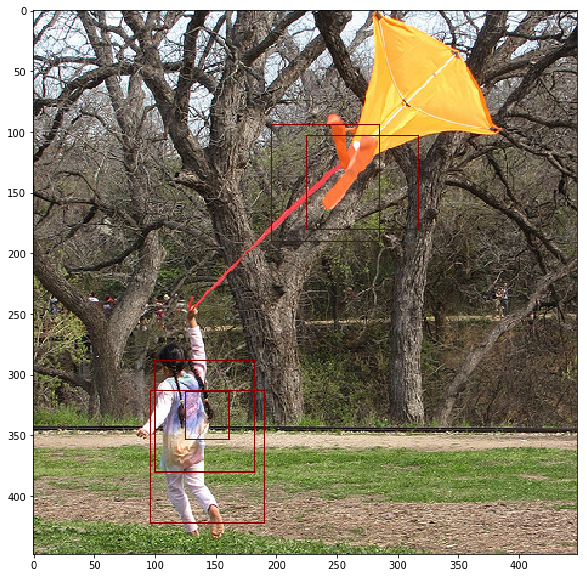

In [59]:
# prediction
demo(img)

In [46]:
chainer.serializers.save_npz('./result/snapshot_iter_5000', trainer)